<a href="https://colab.research.google.com/github/Raychanan/ray_content_final_project/blob/main/content_final_clustering_SUBMIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Raychanan/ray_content_final_project
!pip install git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

Cloning into 'ray_content_final_project'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 29 (delta 9), reused 20 (delta 3), pack-reused 0
Unpacking objects: 100% (29/29), done.
  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-tafoxrmr
  Running command git clone -q git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-tafoxrmr
     |████████████████████████████████| 5.5MB 12.6MB/s 
     |████████████████████████████████| 122kB 49.2MB/s 
     |████████████████████████████████| 163kB 51.4MB/s 
     |████████████████████████████████| 81kB 10.5MB/s 
     |████████████████████████████████| 133kB 61.9MB/s 
     |████████████████████████████████| 32.8MB 162kB/s 
     |████████████████████████████████| 71kB 8.9MB/s 
     |████████████████████████████████| 5.1MB 54.5MB/s 
     |███████████████████████

In [ ]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

In [ ]:
import pandas as pd
covid_df = pd.read_csv("/content/ray_content_final_project/Corona_NLP_train_utf8.csv", header=0)

covid_df.dropna(inplace=True) # dropna
# now_df.drop("Unnamed: 0", axis=1, inplace=True) # drop column
covid_df.rename(columns={'OriginalTweet':'text', "Sentiment":'sentiment'}, inplace=True) #renmae column

covid_df
covid_df = covid_df.sample(n=5000, random_state=123)

In [ ]:
covid_df.reset_index(drop=True, inplace=True)
covid_df

,UserName,ScreenName,Location,TweetAt,text,sentiment
0,11847,56799,"Bandera, Texas",19-03-2020,Gas prices dropping to record lows with NO pla...,Negative
1,27022,71974,Uganda,25-03-2020,ON SALE:\r\r\n\r\r\nFACE MASKS 3PLY AND N95\r\...,Extremely Positive
2,23503,68455,"Salt Lake City, Utah",24-03-2020,The impact of COVID-19 is reaching all the way...,Positive
3,21787,66739,Boston. MA,23-03-2020,3x as many consumers are worried about dying f...,Negative
4,18192,63144,"England, United Kingdom",21-03-2020,How much #toiletpaper is enough? #coronavirus ...,Neutral
...,...,...,...,...,...,...
4995,34189,79141,"Nottingham, England",06-04-2020,Ready to do work - PC issues.\r\r\nEventually ...,Extremely Positive
4996,17897,62849,Earth,21-03-2020,#RealNews trustworthy #worldnews. \r\r\nEmpty ...,Extremely Negative
4997,21510,66462,"Flagstaff, AZ",23-03-2020,Reminder Lumberjacks Scammers are taking advan...,Extremely Positive
4998,7565,52517,"Brooklyn, New York",18-03-2020,To all of those people who are making it a hab...,Positive


# Getting our corpora



In [ ]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(covid_df['text'])
print(newsgroupsVects.shape)

(5000, 19395)


In [ ]:
newsgroupsVects

<5000x19395 sparse matrix of type '<class 'numpy.int64'>'
	with 141079 stored elements in Compressed Sparse Row format>

In [ ]:
newsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

We can also lookup the indices of different words using the Vectorizer

In [ ]:
ngCountVectorizer.vocabulary_.get('vector')

18100

In [ ]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(5000, 19395)


This gives us the tf-idf for each word in each text 

In [ ]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('gas', 0.1296933647816152),
 ('prices', 0.1754793911355651),
 ('dropping', 0.1373567886832822),
 ('to', 0.2896437971037152),
 ('record', 0.12142682989608941),
 ('lows', 0.2500149060853329),
 ('with', 0.3352379363075837),
 ('no', 0.17113928594251718),
 ('place', 0.3482041330620532),
 ('for', 0.18669037854341652),
 ('us', 0.3564215974240977),
 ('go', 0.23202444044534037),
 ('covid19', 0.37944515773331583),
 ('coronavirus', 0.10226171628147658),
 ('oilprices', 0.3352379363075837),
 ('gasprices', 0.1404184630880894),
 ('fuelprices', 0.0848063886021364),
 ('on', 0.16863779256036748),
 ('sale', 0.1940838113892083),
 ('face', 0.2424211315838215)]

In [ ]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(covid_df['text'])

Lets look at the matrix

In [ ]:
covid_df['text']

0       Gas prices dropping to record lows with NO pla...
1       ON SALE:\r\r\n\r\r\nFACE MASKS 3PLY AND N95\r\...
2       The impact of COVID-19 is reaching all the way...
3       3x as many consumers are worried about dying f...
4       How much #toiletpaper is enough? #coronavirus ...
                              ...                        
4995    Ready to do work - PC issues.\r\r\nEventually ...
4996    #RealNews trustworthy #worldnews. \r\r\nEmpty ...
4997    Reminder Lumberjacks Scammers are taking advan...
4998    To all of those people who are making it a hab...
4999    COVID 19-  Panic buying at supermarket! https:...
Name: text, Length: 5000, dtype: object

The matrix is much smaller now, only 1000 words, but the same number of documents 

In [ ]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['gas', 'prices', 'record', 'place', 'covid19', 'coronavirus', 'sale', 'face', 'masks', 'covid'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means

To do this we will need to know how many clusters we are looking for. I know it's 5

In [ ]:
covid_df['category'] = covid_df['sentiment']
numClusters = len(set(covid_df['category']))
numClusters

5

Then we can initialize our cluster finder

In [ ]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [ ]:
km.fit(newsgroupsTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(covid_df['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(covid_df['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(covid_df['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(covid_df['category'], km.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'PrecisionRecallDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'calinski_harabaz_score', 'check_scoring', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'davies_bouldin_score', 'dcg_score', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_gamma_deviance', 'mean_poisson_deviance', 'mean_squared_error', 'mean_squared_log_error', '

In [ ]:
covid_df['kmeans_predictions'] = km.labels_
covid_df

,UserName,ScreenName,Location,TweetAt,text,sentiment,category,kmeans_predictions
0,11847,56799,"Bandera, Texas",19-03-2020,Gas prices dropping to record lows with NO pla...,Negative,Negative,1
1,27022,71974,Uganda,25-03-2020,ON SALE:\r\r\n\r\r\nFACE MASKS 3PLY AND N95\r\...,Extremely Positive,Extremely Positive,1
2,23503,68455,"Salt Lake City, Utah",24-03-2020,The impact of COVID-19 is reaching all the way...,Positive,Positive,1
3,21787,66739,Boston. MA,23-03-2020,3x as many consumers are worried about dying f...,Negative,Negative,4
4,18192,63144,"England, United Kingdom",21-03-2020,How much #toiletpaper is enough? #coronavirus ...,Neutral,Neutral,0
...,...,...,...,...,...,...,...,...
4995,34189,79141,"Nottingham, England",06-04-2020,Ready to do work - PC issues.\r\r\nEventually ...,Extremely Positive,Extremely Positive,3
4996,17897,62849,Earth,21-03-2020,#RealNews trustworthy #worldnews. \r\r\nEmpty ...,Extremely Negative,Extremely Negative,3
4997,21510,66462,"Flagstaff, AZ",23-03-2020,Reminder Lumberjacks Scammers are taking advan...,Extremely Positive,Extremely Positive,4
4998,7565,52517,"Brooklyn, New York",18-03-2020,To all of those people who are making it a hab...,Positive,Positive,3


We can also look at the distinguishing features in each cluster

In [ ]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 sanitizer
 coronavirus
 toiletpaper
 hand
 covid19
 toilet
 paper
 hands
 use
 covid_19


Cluster 1:
 prices
 oil
 coronavirus
 19
 covid
 gas
 price
 amp
 market
 pandemic


Cluster 2:
 store
 grocery
 coronavirus
 workers
 covid_19
 people
 going
 retail
 covid19
 employees


Cluster 3:
 coronavirus
 supermarket
 food
 amp
 consumer
 people
 covid19
 shopping
 panic
 online


Cluster 4:
 19
 covid
 consumer
 food
 online
 shopping
 supermarket
 demand
 pandemic
 people




Let's construct a visualization of the clusters

In [ ]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [ ]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [ ]:
covid_df['category'].unique()

array(['Negative', 'Extremely Positive', 'Positive', 'Neutral',
       'Extremely Negative'], dtype=object)

In [ ]:
colordict = {
'Negative': 'red',
'Extremely Positive': 'orange',
'Positive': 'green',
'Neutral': 'blue',
'Extremely Negative': 'purple',
    }
colors = [colordict[c] for c in covid_df['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('Negative', 'red'), ('Extremely Positive', 'orange'), ('Positive', 'green'), ('Neutral', 'blue'), ('Extremely Negative', 'purple')])


Let's plot the data using the true labels as the colors of our data points.

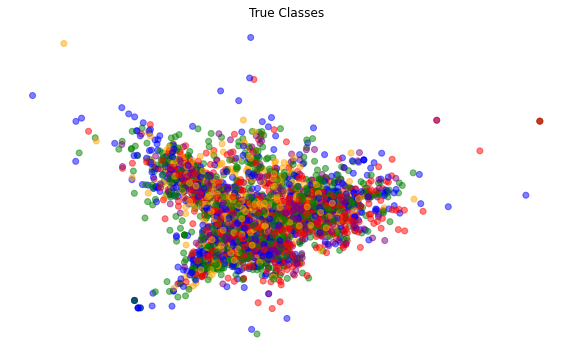

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot

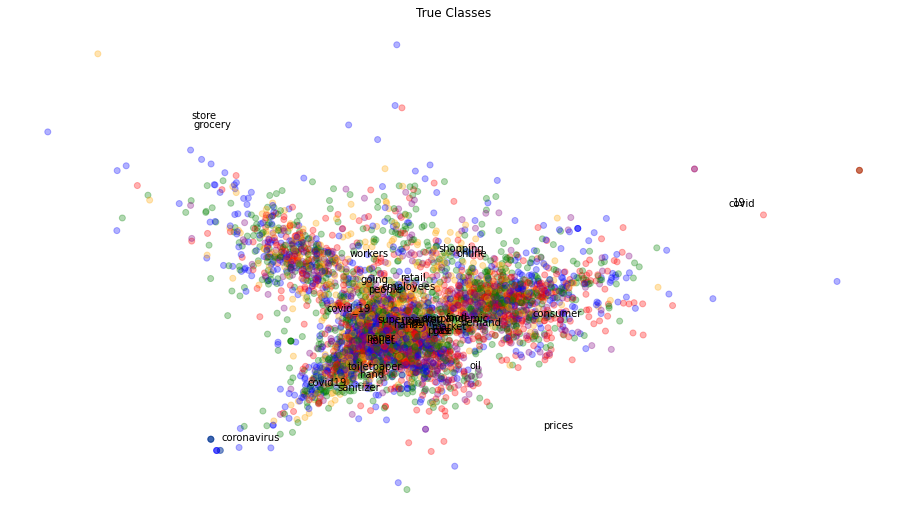

In [ ]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters

In [ ]:
newsgroupsCategories = ['Negative', 'Extremely Positive', 'Positive', 'Neutral',
                        'Extremely Negative']

colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

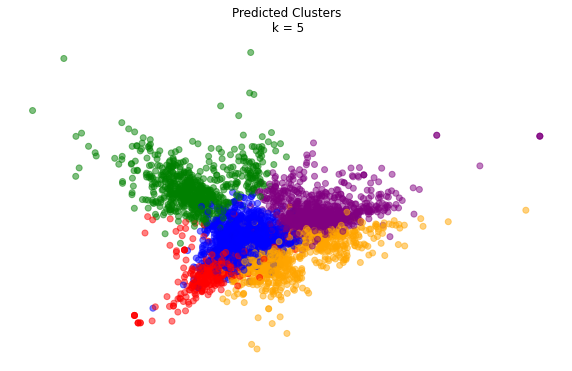

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 5')
plt.show()

# Selecting Cluster Number

In [ ]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


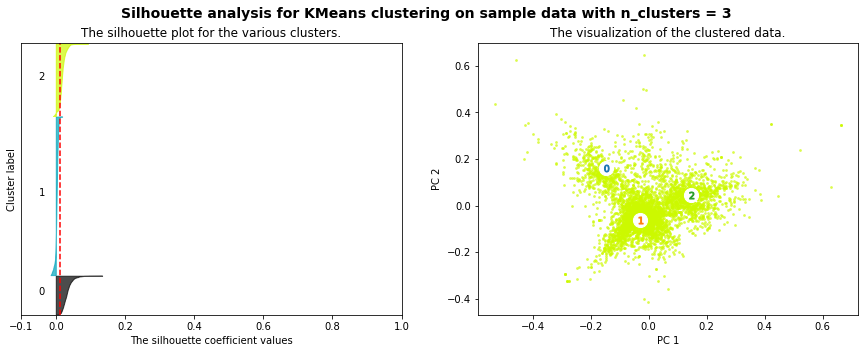

For n_clusters = 3, The average silhouette_score is : 0.011


In [ ]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


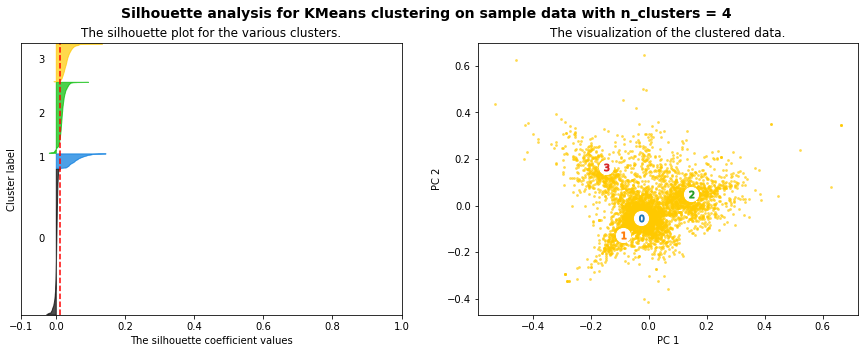

For n_clusters = 4, The average silhouette_score is : 0.013


In [ ]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


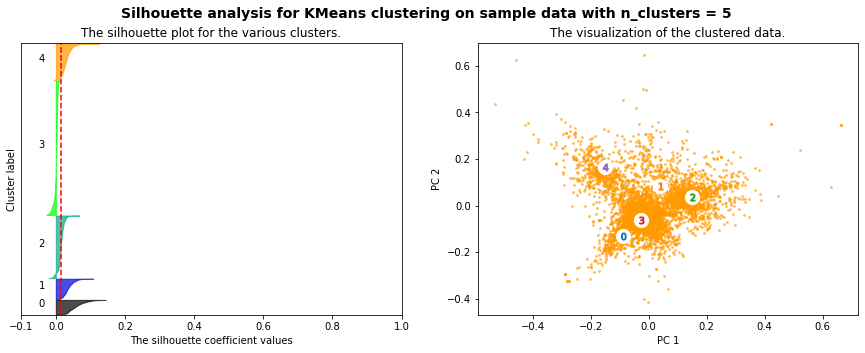

For n_clusters = 5, The average silhouette_score is : 0.014


In [ ]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


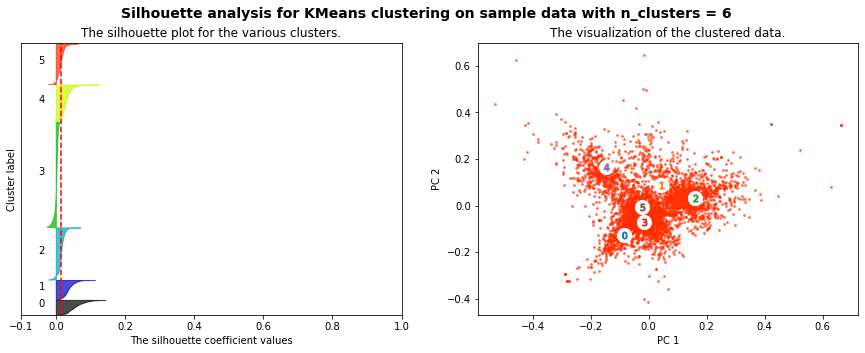

For n_clusters = 6, The average silhouette_score is : 0.015


In [ ]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores are not changing much

# Hierarchical Clustering with Wald's Method


In [ ]:
newsgroupsTFVects

<5000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 51617 stored elements in Compressed Sparse Row format>

In [ ]:
newsgroupsTFVects[:100].todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts

In [ ]:
selectIndices = []
indexToCat = []
for c in set(covid_df['category']):
    selectIndices += list(covid_df[covid_df['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [ ]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [ ]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[117.        , 138.        ,   0.        ,   2.        ],
       [242.        , 250.        ,   0.32286511,   3.        ],
       [ 11.        , 180.        ,   0.47980322,   2.        ],
       [  5.        , 229.        ,   0.49438467,   2.        ],
       [ 20.        , 252.        ,   0.49478085,   3.        ],
       [123.        , 216.        ,   0.5046706 ,   2.        ],
       [  9.        , 251.        ,   0.50689957,   4.        ],
       [  7.        , 254.        ,   0.50817913,   4.        ],
       [ 40.        ,  49.        ,   0.52112639,   2.        ],
       [ 44.        , 198.        ,   0.52994962,   2.        ]])

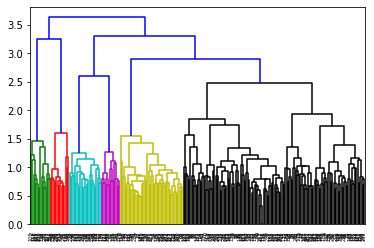

In [ ]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

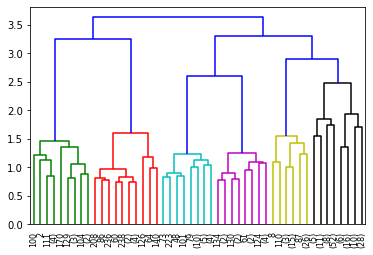

In [ ]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=5, truncate_mode='level', get_leaves=True)

In [ ]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 5, 'maxclust')
hierarchicalClusters

array([5, 4, 1, 5, 5, 5, 5, 4, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5,
       5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 1, 3, 3, 4, 5, 5, 5,
       4, 5, 5, 5, 3, 4, 4, 5, 3, 3, 5, 1, 3, 3, 5, 5, 2, 3, 5, 5, 2, 5,
       5, 2, 3, 4, 5, 4, 5, 3, 4, 5, 2, 3, 5, 3, 5, 5, 5, 5, 5, 5, 2, 4,
       5, 4, 3, 4, 5, 5, 5, 5, 3, 5, 5, 4, 1, 3, 5, 5, 1, 5, 3, 5, 1, 2,
       4, 1, 5, 5, 5, 4, 5, 5, 3, 5, 5, 4, 3, 4, 3, 1, 2, 4, 5, 1, 3, 5,
       3, 5, 3, 4, 5, 5, 5, 5, 2, 5, 3, 3, 3, 3, 5, 1, 5, 5, 4, 5, 5, 5,
       5, 5, 5, 5, 3, 5, 5, 4, 5, 5, 4, 5, 5, 1, 5, 5, 1, 5, 4, 3, 3, 5,
       5, 4, 5, 5, 4, 1, 5, 5, 5, 4, 5, 3, 5, 4, 5, 5, 4, 5, 5, 4, 4, 5,
       4, 3, 4, 5, 4, 5, 5, 5, 5, 1, 2, 1, 5, 5, 3, 5, 5, 3, 4, 4, 5, 3,
       5, 5, 4, 3, 4, 5, 3, 5, 5, 5, 4, 3, 5, 5, 4, 2, 2, 4, 2, 2, 5, 4,
       5, 4, 5, 5, 5, 5, 2, 3], dtype=int32)

In [ ]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 5, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(covid_df['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(covid_df['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(covid_df['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(covid_df['category'], hierarchicalClusters_full)))

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


For our complete clusters:
Homogeneity: 0.012
Completeness: 0.013
V-measure: 0.013
Adjusted Rand Score: 0.002


better than $k$-means

In [ ]:
covid_df['wald_predictions'] = hierarchicalClusters_full
covid_df

,UserName,ScreenName,Location,TweetAt,text,sentiment,category,kmeans_predictions,wald_predictions
0,11847,56799,"Bandera, Texas",19-03-2020,Gas prices dropping to record lows with NO pla...,Negative,Negative,1,5
1,27022,71974,Uganda,25-03-2020,ON SALE:\r\r\n\r\r\nFACE MASKS 3PLY AND N95\r\...,Extremely Positive,Extremely Positive,2,2
2,23503,68455,"Salt Lake City, Utah",24-03-2020,The impact of COVID-19 is reaching all the way...,Positive,Positive,2,2
3,21787,66739,Boston. MA,23-03-2020,3x as many consumers are worried about dying f...,Negative,Negative,2,2
4,18192,63144,"England, United Kingdom",21-03-2020,How much #toiletpaper is enough? #coronavirus ...,Neutral,Neutral,1,3
...,...,...,...,...,...,...,...,...,...
4995,34189,79141,"Nottingham, England",06-04-2020,Ready to do work - PC issues.\r\r\nEventually ...,Extremely Positive,Extremely Positive,1,5
4996,17897,62849,Earth,21-03-2020,#RealNews trustworthy #worldnews. \r\r\nEmpty ...,Extremely Negative,Extremely Negative,1,4
4997,21510,66462,"Flagstaff, AZ",23-03-2020,Reminder Lumberjacks Scammers are taking advan...,Extremely Positive,Extremely Positive,2,2
4998,7565,52517,"Brooklyn, New York",18-03-2020,To all of those people who are making it a hab...,Positive,Positive,1,5


# Gensim



In [ ]:
#Apply our functions
covid_df['tokenized_text'] = covid_df['text'].apply(lambda x: lucem_illud.word_tokenize(x))
covid_df['normalized_tokens'] = covid_df['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [ ]:
covid_df[::100]

,UserName,ScreenName,Location,TweetAt,text,sentiment,category,kmeans_predictions,wald_predictions,tokenized_text,normalized_tokens,reduced_tokens
0,11847,56799,"Bandera, Texas",19-03-2020,Gas prices dropping to record lows with NO pla...,Negative,Negative,1,5,"[Gas, prices, dropping, to, record, lows, with...","[gas, price, drop, record, low, place, covid19...","[gas, drop, record, low, place, oilprices, gas..."
100,41989,86941,Tunbridge Wells,11-04-2020,You practise #SocialDistancing for an hour in ...,Extremely Negative,Extremely Negative,1,5,"[You, practise, SocialDistancing, for, an, hou...","[practise, socialdistancing, hour, queue, supe...","[practise, hour, queue, soon, inside, bet, wtf..."
200,5001,49953,#Alpes,17-03-2020,La fin du monde ?? https://t.co/vwfTbmrM6o,Neutral,Neutral,1,5,"[La, fin, du, monde, https://t.co/vwfTbmrM6o]","[la, fin, du, monde, https://t.co/vwftbmrm6o]","[la, du]"
300,32637,77589,"Oadby, Leicester ??",05-04-2020,I still canÂ’t believe that families are shopp...,Extremely Positive,Extremely Positive,1,5,"[I, still, canÂ’t, believe, that, families, ar...","[canâ’t, believe, family, shop, bite, stay, ho...","[believe, family, understand, shopper, worker,..."
400,21799,66751,near Guildford,23-03-2020,"@paulmasonnews Every single bar, pub, club, co...",Positive,Positive,1,5,"[@paulmasonnews, Every, single, bar, pub, club...","[@paulmasonnews, single, bar, pub, club, coffe...","[single, bar, pub, club, coffee, restaurant, d..."
500,34906,79858,"Omaha, Nebraska",06-04-2020,Â“The chance to make an impact in the communit...,Neutral,Neutral,1,5,"[Â“The, chance, to, make, an, impact, in, the,...","[â“the, chance, impact, community, rare, priso...","[chance, community, rare, prison, nebraska]"
600,19923,64875,"Miami, FL",22-03-2020,Dime Algo?\r\r\nA word of wisdom from an old m...,Extremely Positive,Extremely Positive,1,5,"[Dime, Algo, A, word, of, wisdom, from, an, ol...","[dime, algo, word, wisdom, old, man, survive, ...","[word, old, man, survive, money, loyalty, rela..."
700,36248,81200,"Baroda,Gujarat,India",07-04-2020,""" Go Corona Go ""\r\r\n\r\r\n#gocoronago #coron...",Neutral,Neutral,1,3,"[Go, Corona, Go, gocoronago, coronavirus, covi...","[corona, gocoronago, coronavirus, covid, covid...","[corona, covid19india, stayhome, chinavirus]"
800,20173,65125,"Deerfield, IL",22-03-2020,The beginning of our week of confinement https...,Neutral,Neutral,0,1,"[The, beginning, of, our, week, of, confinemen...","[begin, week, confinement, https://t.co/m8emjt...","[begin, confinement, public, place]"
900,37340,82292,"Argyle, NY",08-04-2020,"Amid coronavirus concerns, scammers are using ...",Negative,Negative,1,2,"[Amid, coronavirus, concerns, scammers, are, u...","[amid, coronavirus, concern, scammer, fake, we...","[amid, concern, fake, website, email, text, me..."


In [ ]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(covid_df['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

In [ ]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

covid_df['reduced_tokens'] = covid_df['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [ ]:
dictionary = gensim.corpora.Dictionary(covid_df['reduced_tokens'])

In [ ]:
corpus = [dictionary.doc2bow(text) for text in covid_df['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [ ]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [ ]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=5, alpha='auto', eta='auto')

In [ ]:
sen1Bow = dictionary.doc2bow(covid_df['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(covid_df['category'][0]))
print("are: {}".format(sen1lda))

The topics of the text: Negative
are: [(0, 0.017016228), (1, 0.017460978), (2, 0.016329266), (3, 0.019003205), (4, 0.9301904)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [ ]:
ldaDF = pandas.DataFrame({
        'category' : covid_df['category'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in covid_df['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column

In [ ]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,category,topics,topic_0,topic_1,topic_2,topic_3,topic_4
1,Extremely Positive,"[(0, 0.010131873), (1, 0.4655415), (3, 0.01132...",0.010132,0.465542,0.000000,0.011321,0.503290
101,Negative,"[(0, 0.013927116), (1, 0.014260703), (2, 0.013...",0.013927,0.014261,0.013318,0.944884,0.013611
201,Negative,"[(0, 0.011724023), (1, 0.68497974), (2, 0.2787...",0.011724,0.684980,0.278793,0.013042,0.011461
301,Neutral,"[(0, 0.19695424), (1, 0.20205615), (2, 0.18890...",0.196954,0.202056,0.188906,0.219016,0.193068
401,Positive,"[(0, 0.01707242), (1, 0.3602326), (2, 0.016362...",0.017072,0.360233,0.016363,0.019068,0.587264
501,Extremely Positive,"[(2, 0.9608065), (3, 0.010613563)]",0.000000,0.000000,0.960806,0.010614,0.000000
601,Neutral,"[(0, 0.0221156), (1, 0.9102532), (2, 0.0212560...",0.022116,0.910253,0.021256,0.024729,0.021646
701,Negative,"[(0, 0.01268294), (1, 0.013032325), (2, 0.0122...",0.012683,0.013032,0.012223,0.014150,0.947912
801,Extremely Negative,"[(0, 0.03966812), (1, 0.83895046), (2, 0.03834...",0.039668,0.838950,0.038348,0.044172,0.038861
901,Positive,"[(0, 0.57626504), (1, 0.026680557), (2, 0.0248...",0.576265,0.026681,0.024856,0.028838,0.343361


Now let's visualize this for several (e.g., 5) documents in the corpus.

In [ ]:
ldaDFV = ldaDF[:5][['topic_%d' %x for x in range(5)]]
ldaDFVisN = ldaDF[:5][['category']]
ldaDFVis = ldaDFV.to_numpy()
ldaDFVisNames = ldaDFVisN.to_numpy()
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4
0,0.017016,0.017461,0.016329,0.019002,0.930191
1,0.010132,0.465542,0.000000,0.011321,0.503290
2,0.022112,0.022660,0.021162,0.024787,0.909279
3,0.019301,0.019809,0.018489,0.923345,0.019055
4,0.196954,0.202056,0.188906,0.219016,0.193068


First we can visualize as a stacked bar chart

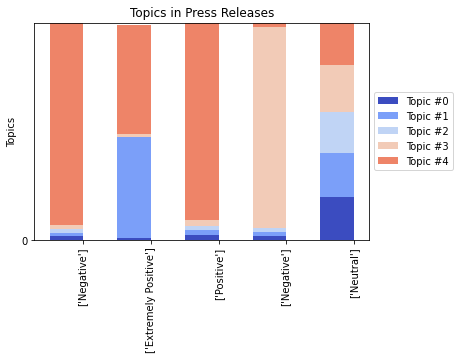

In [ ]:
N = 5
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 5))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map

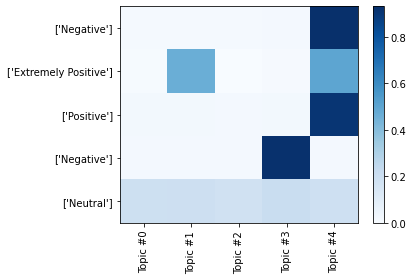

In [ ]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic

In [ ]:
senlda.show_topic(1)

[('mask', 0.01709377),
 ('worker', 0.012036109),
 ('high', 0.007383896),
 ('wear', 0.007320759),
 ('come', 0.005752729),
 ('uk', 0.0055284584),
 ('say', 0.0048014475),
 ('face', 0.0046852636),
 ('product', 0.004461046),
 ('change', 0.0042941733)]

And if we want to make a dataFrame:

In [ ]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,order,mask,worker,report,gas
1,worker,worker,say,customer,thank
2,self,high,economy,employee,low
3,chain,wear,free,try,feel
4,share,come,change,hour,let
5,live,uk,pay,state,support
6,open,say,look,march,walk
7,increase,face,thing,company,look
8,isolate,product,product,check,news
9,item,change,job,job,year


<Figure size 432x288 with 0 Axes>

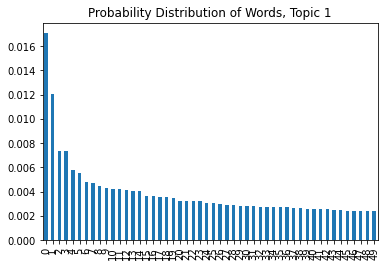

In [ ]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.看看不同的$eta$值如何改变分布的形状。

In [ ]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=5, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=5, eta = 0.9)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:807: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


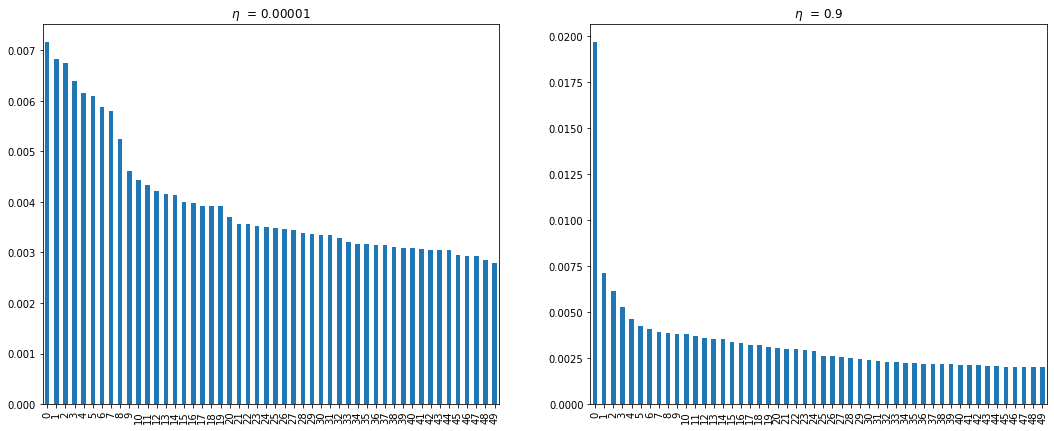

In [ ]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()